# Практическая работа 2

## Выполнил: __Щеткин Дмитрий Сергеевич__

группа 2.1

### **Оглавление**

1. Введение
2. Понимание бизнес-задачи
3. Понимание данных
4. Подготовка данных
5. Моделирование
6. Оценка
7. Визуализация и представление результатов
8. Общие выводы по работе


### **1. Введение**

В ходе выполнения работы были пройдены основные этапы методологии CRISP-DM (Cross-Industry Standard Process
for Data Mining), за исключением этапа внедрения (Deployment), для анализа данных опроса студентов.

Основной задачей являлось выявление скрытых групп (кластеров) студентов на основе их ответов, что позволяло лучше понять их предпочтения и потребности в образовательном процессе.

Особое внимание было уделено работе с бинарными категориальными признаками, выбору подходящих методов снижения размерности и алгоритмов кластеризации, а также интерпретации и визуализации полученных результатов.

### **2. Понимание бизнес-задачи**

**Цель.** Сегментировать студентов на основе их ответов в анкете, касающейся различных аспектов учебного процесса
(использование образовательных платформ, предпочтения по обратной связи, форматы материалов и т.д.).

**Задачи, которые необходимо решить в рамках этого этапа:**
- Сформулировать, как выявление различных групп студентов может помочь университету. Например, для персонализации учебных материалов, разработки целевых программ поддержки, оптимизации использования образовательных технологий или улучшения взаимодействия между
студентами и преподавателями.
- Определитить, какие конкретные вопросы из анкеты могут быть наиболее информативными для разделения студентов на группы с различными характеристиками и потребностями.
- Проанализировать, какие
ожидаемые результаты кластеризации будут считаться успешными и полезными для университета.

### **3. Понимание данных**

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import chi2_contingency

In [3]:
# Загрузка данных
file_path = 'data/dlia studentov.xlsx'
df = pd.read_excel(file_path)
df.head()

,ID,Время создания,На каком факультете/в каком институте Вы обучаетесь?,"Какая платформа для обучения дисциплине ""ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ"" использовалась?","Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)","Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?","Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)","Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?","Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?","Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?",...,Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?,Были ли встроенны в электронный курс видеолекции?,Необходимо ли встраивать в электронный курс видеолекции?,Были ли встроенные в электронный курс тесты по материалом видео лекций?,Была ли предусмотрена рефлексия (отзыв) после выполнения каждого практического задания?,Необходима ли рефлексия (отзыв) после выполнения каждого практического задания?,Была ли предусмотрена рефлексия (отзыв) после завершения работы по дисциплине?,Необходима ли рефлексия (отзыв) после завершения работы по дисциплине?,Было ли организовано взаимодействие с преподавателями посредством мессенджеров?,Необходимо ли организовывать взаимодействие с преподавателями посредством мессенджеров?
0,1408291245,2023-06-07 20:41:17,институт истории и социальных наук,Moodle,нет,нет,нет,нет,да,нет,...,да,да,нет,да,нет,да,нет,да,да,да
1,1405883214,2023-06-05 09:02:21,институт педагогики,Moodle,да,да,нет,да,нет,да,...,да,да,да,да,да,да,да,да,да,да
2,1405869646,2023-06-05 08:44:38,институт педагогики,Moodle,да,да,да,да,да,да,...,да,да,да,да,да,да,да,да,да,да
3,1405856131,2023-06-05 08:26:39,институт педагогики,Moodle,да,да,нет,нет,да,да,...,да,да,да,да,да,да,да,да,да,да
4,1405854542,2023-06-05 08:24:47,институт педагогики,Moodle,да,да,нет,нет,да,да,...,да,да,да,да,нет,нет,да,нет,нет,да


In [4]:
# Первичный осмотр данных

print(f"Размерность данных: {df.shape}")

print("\nТипы данных:")
print(df.dtypes)

print("\nКоличество пропущенных значений:")
print(df.isnull().sum())

Размерность данных: (711, 23)

Типы данных:
ID                                                                                                                                             int64
Время создания                                                                                                                                object
На каком факультете/в каком институте Вы обучаетесь?                                                                                          object
Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?                                                     object
Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)                  object
Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?    object
Был ли автоматический мониторинг присутствия студента на занят

<ipython-input-5-3ea304cc6f89>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df_cleaned.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)


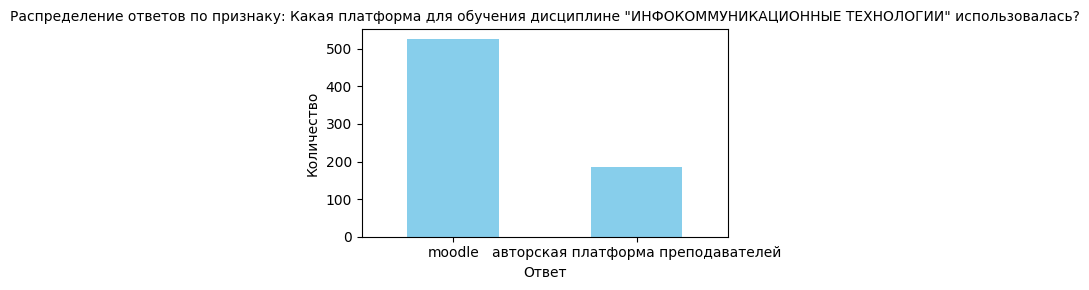

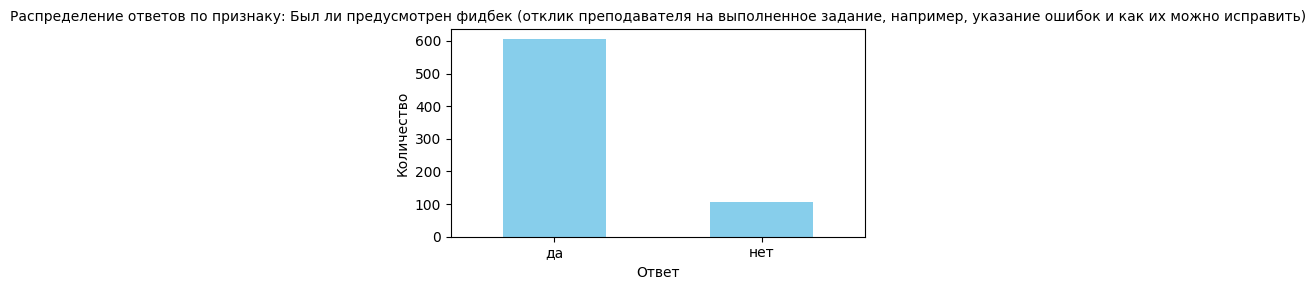

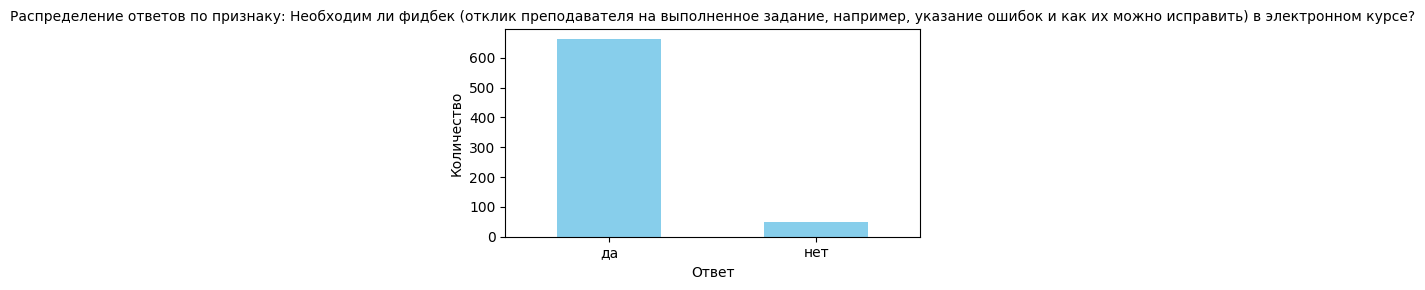

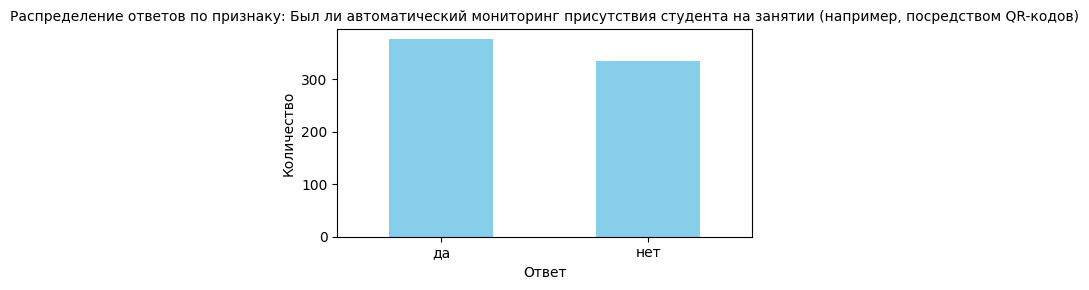

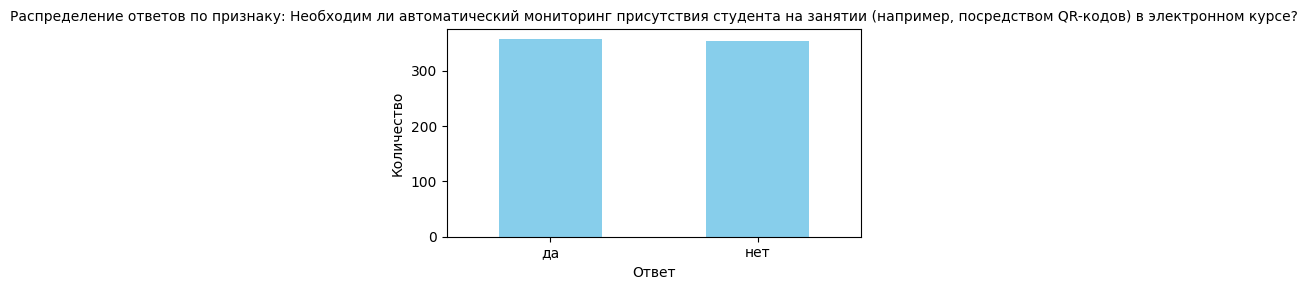

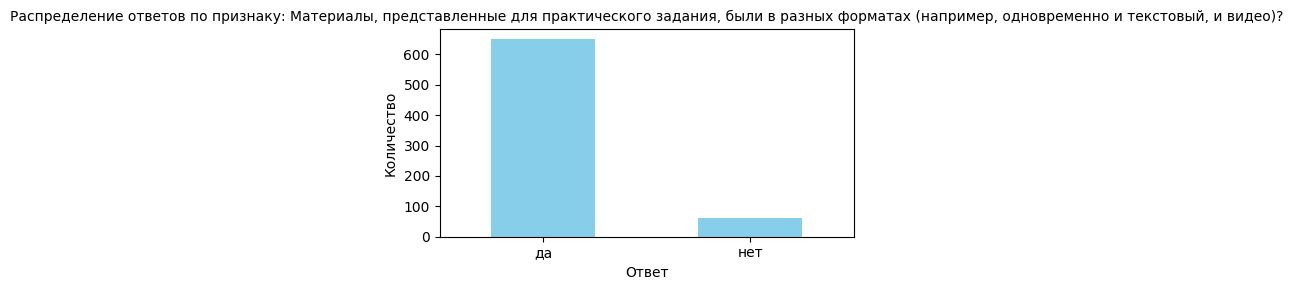

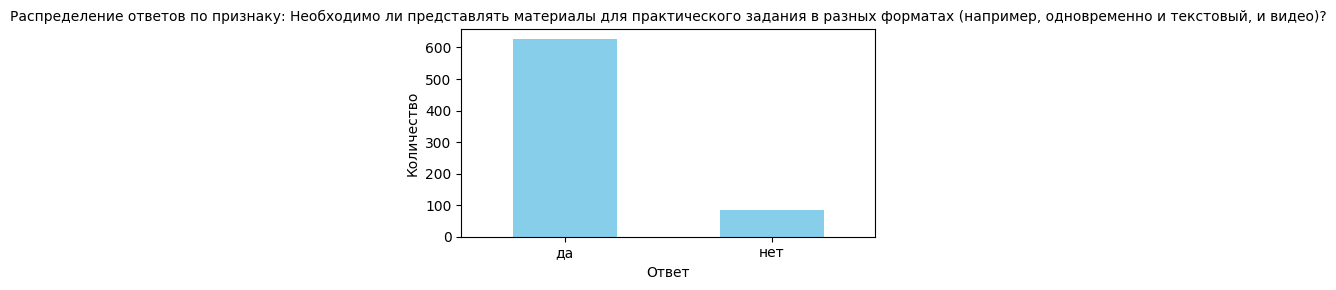

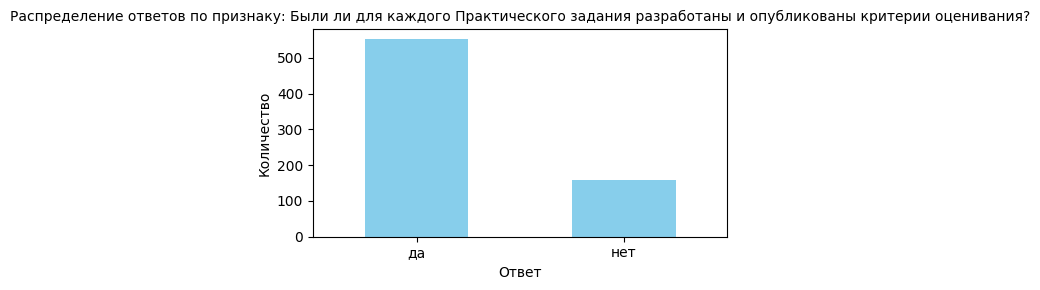

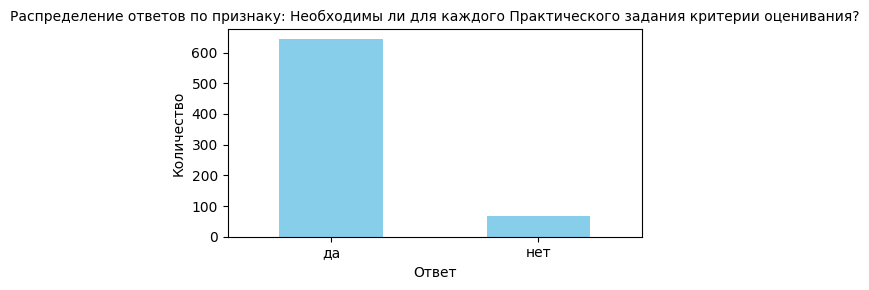

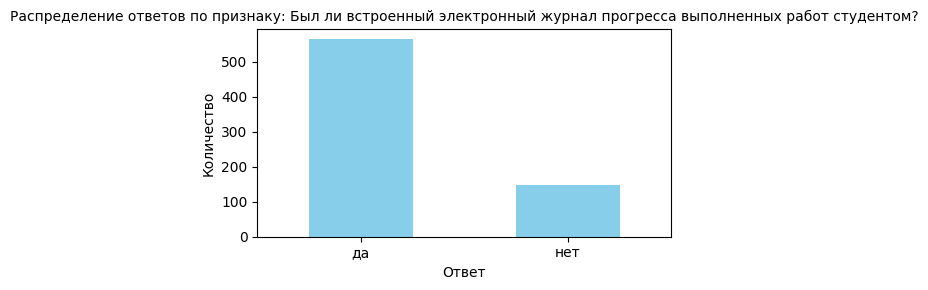

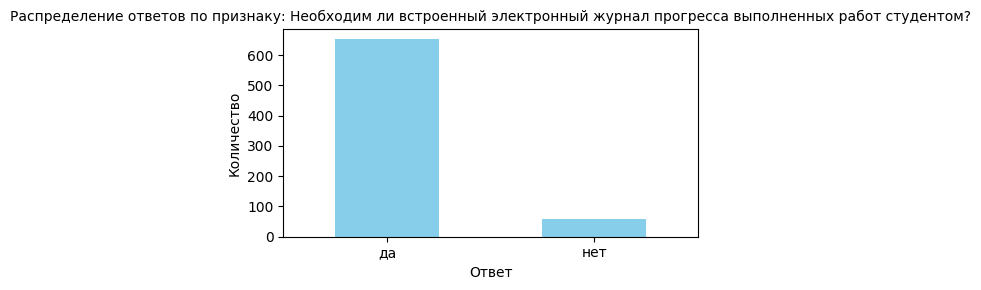

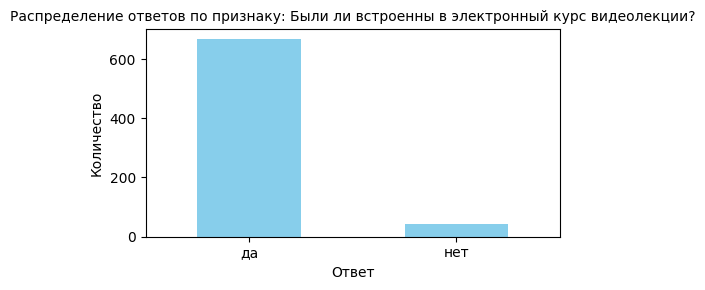

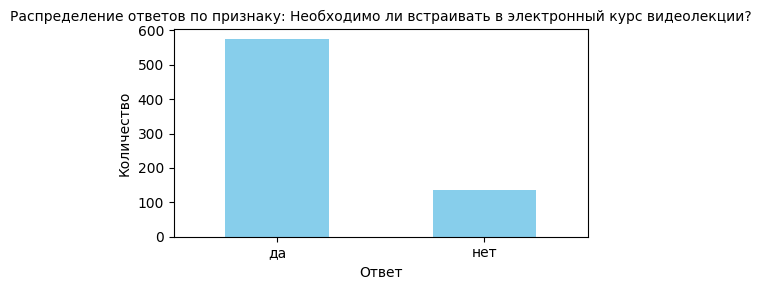

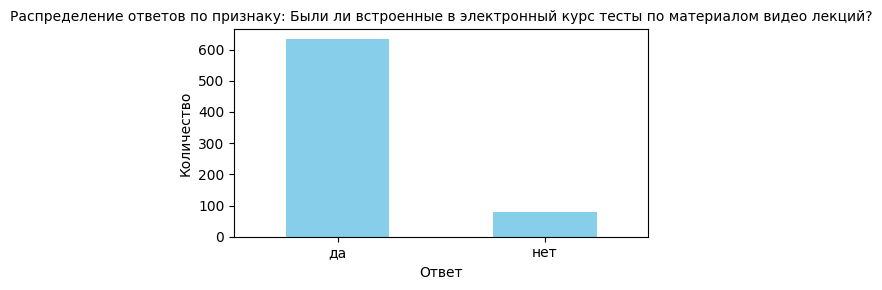

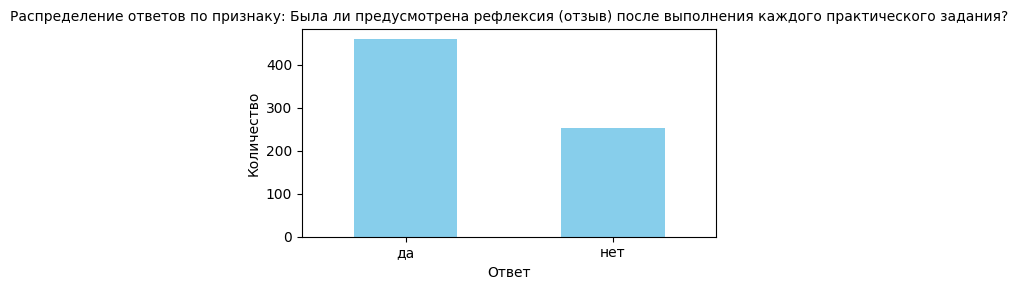

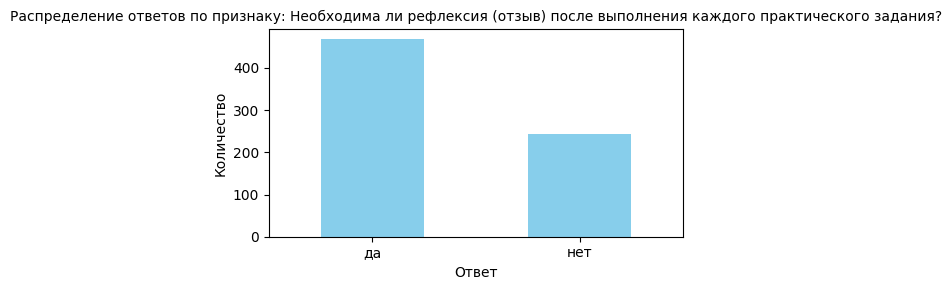

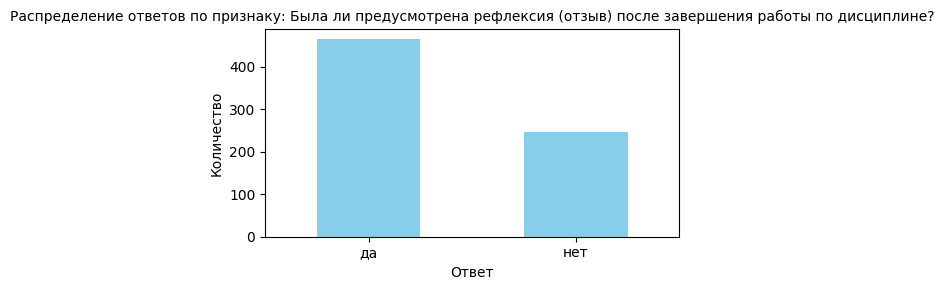

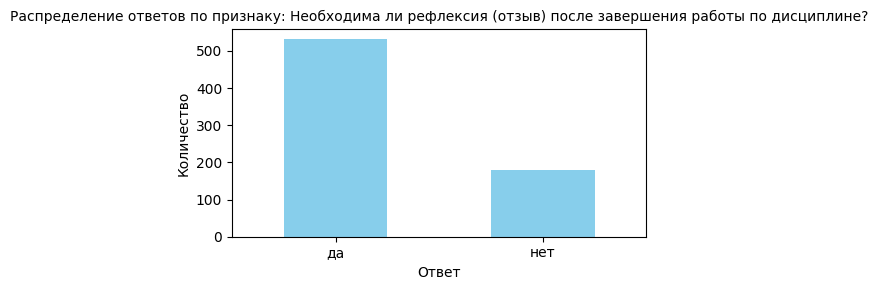

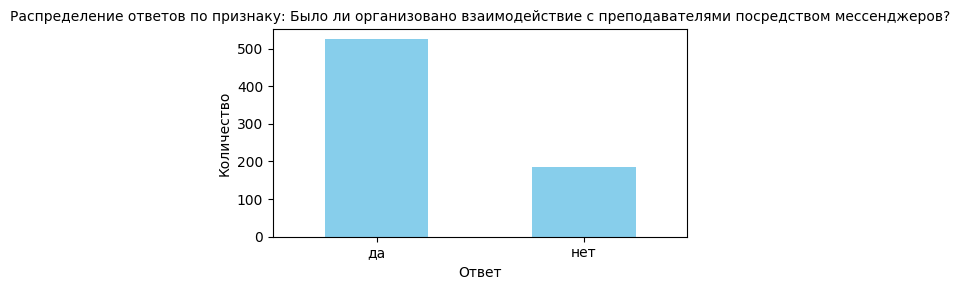

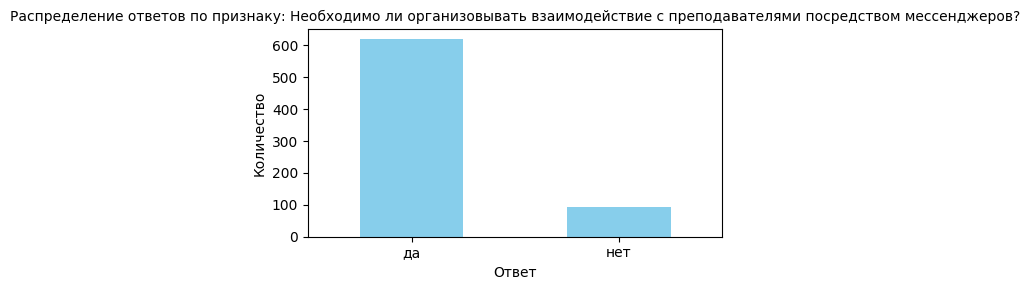

In [5]:
# Просмотр категориальных признаков
# Преобразуем все значения к нижнему регистру для унификации
df_cleaned = df.copy()
df_cleaned = df_cleaned.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)

# Список бинарных признаков (начиная с 4-го столбца)
binary_columns = df_cleaned.columns[3:]

# Просмотр распределения по каждому бинарному признаку
for col in binary_columns:
    plt.figure(figsize=(5, 3))
    df_cleaned[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Распределение ответов по признаку: {col}', fontsize=10)
    plt.xlabel('Ответ')
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [6]:
# Подсчёт частоты ответов "да" и "нет" для бинарных признаков
binary_summary = df_cleaned[binary_columns].apply(lambda col: col.value_counts())
print(binary_summary.T)

                                                    moodle  \
Какая платформа для обучения дисциплине "ИНФОКО...   525.0   
Был ли предусмотрен фидбек (отклик преподавател...     NaN   
Необходим ли фидбек (отклик преподавателя на вы...     NaN   
Был ли автоматический мониторинг присутствия ст...     NaN   
Необходим ли автоматический мониторинг присутст...     NaN   
Материалы, представленные для практического зад...     NaN   
Необходимо ли представлять материалы для практи...     NaN   
Были ли для каждого Практического задания разра...     NaN   
Необходимы ли для каждого Практического задания...     NaN   
Был ли встроенный электронный журнал прогресса ...     NaN   
Необходим ли встроенный электронный журнал прог...     NaN   
Были ли встроенны в электронный курс видеолекции?      NaN   
Необходимо ли встраивать в электронный курс вид...     NaN   
Были ли встроенные в электронный курс тесты по ...     NaN   
Была ли предусмотрена рефлексия (отзыв) после в...     NaN   
Необходи

In [8]:
# Функция для расчета коэффициента Фи
def phi_coefficient(col1, col2):
    contingency_table = pd.crosstab(col1, col2)
    if contingency_table.shape == (2, 2):
        a = contingency_table.iloc[1, 1]
        b = contingency_table.iloc[1, 0]
        c = contingency_table.iloc[0, 1]
        d = contingency_table.iloc[0, 0]
        numerator = (a * d - b * c)
        denominator = np.sqrt((a + b)*(c + d)*(a + c)*(b + d))
        return numerator / denominator if denominator != 0 else 0
    else:
        return np.nan

<ipython-input-9-b366928ddb41>:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


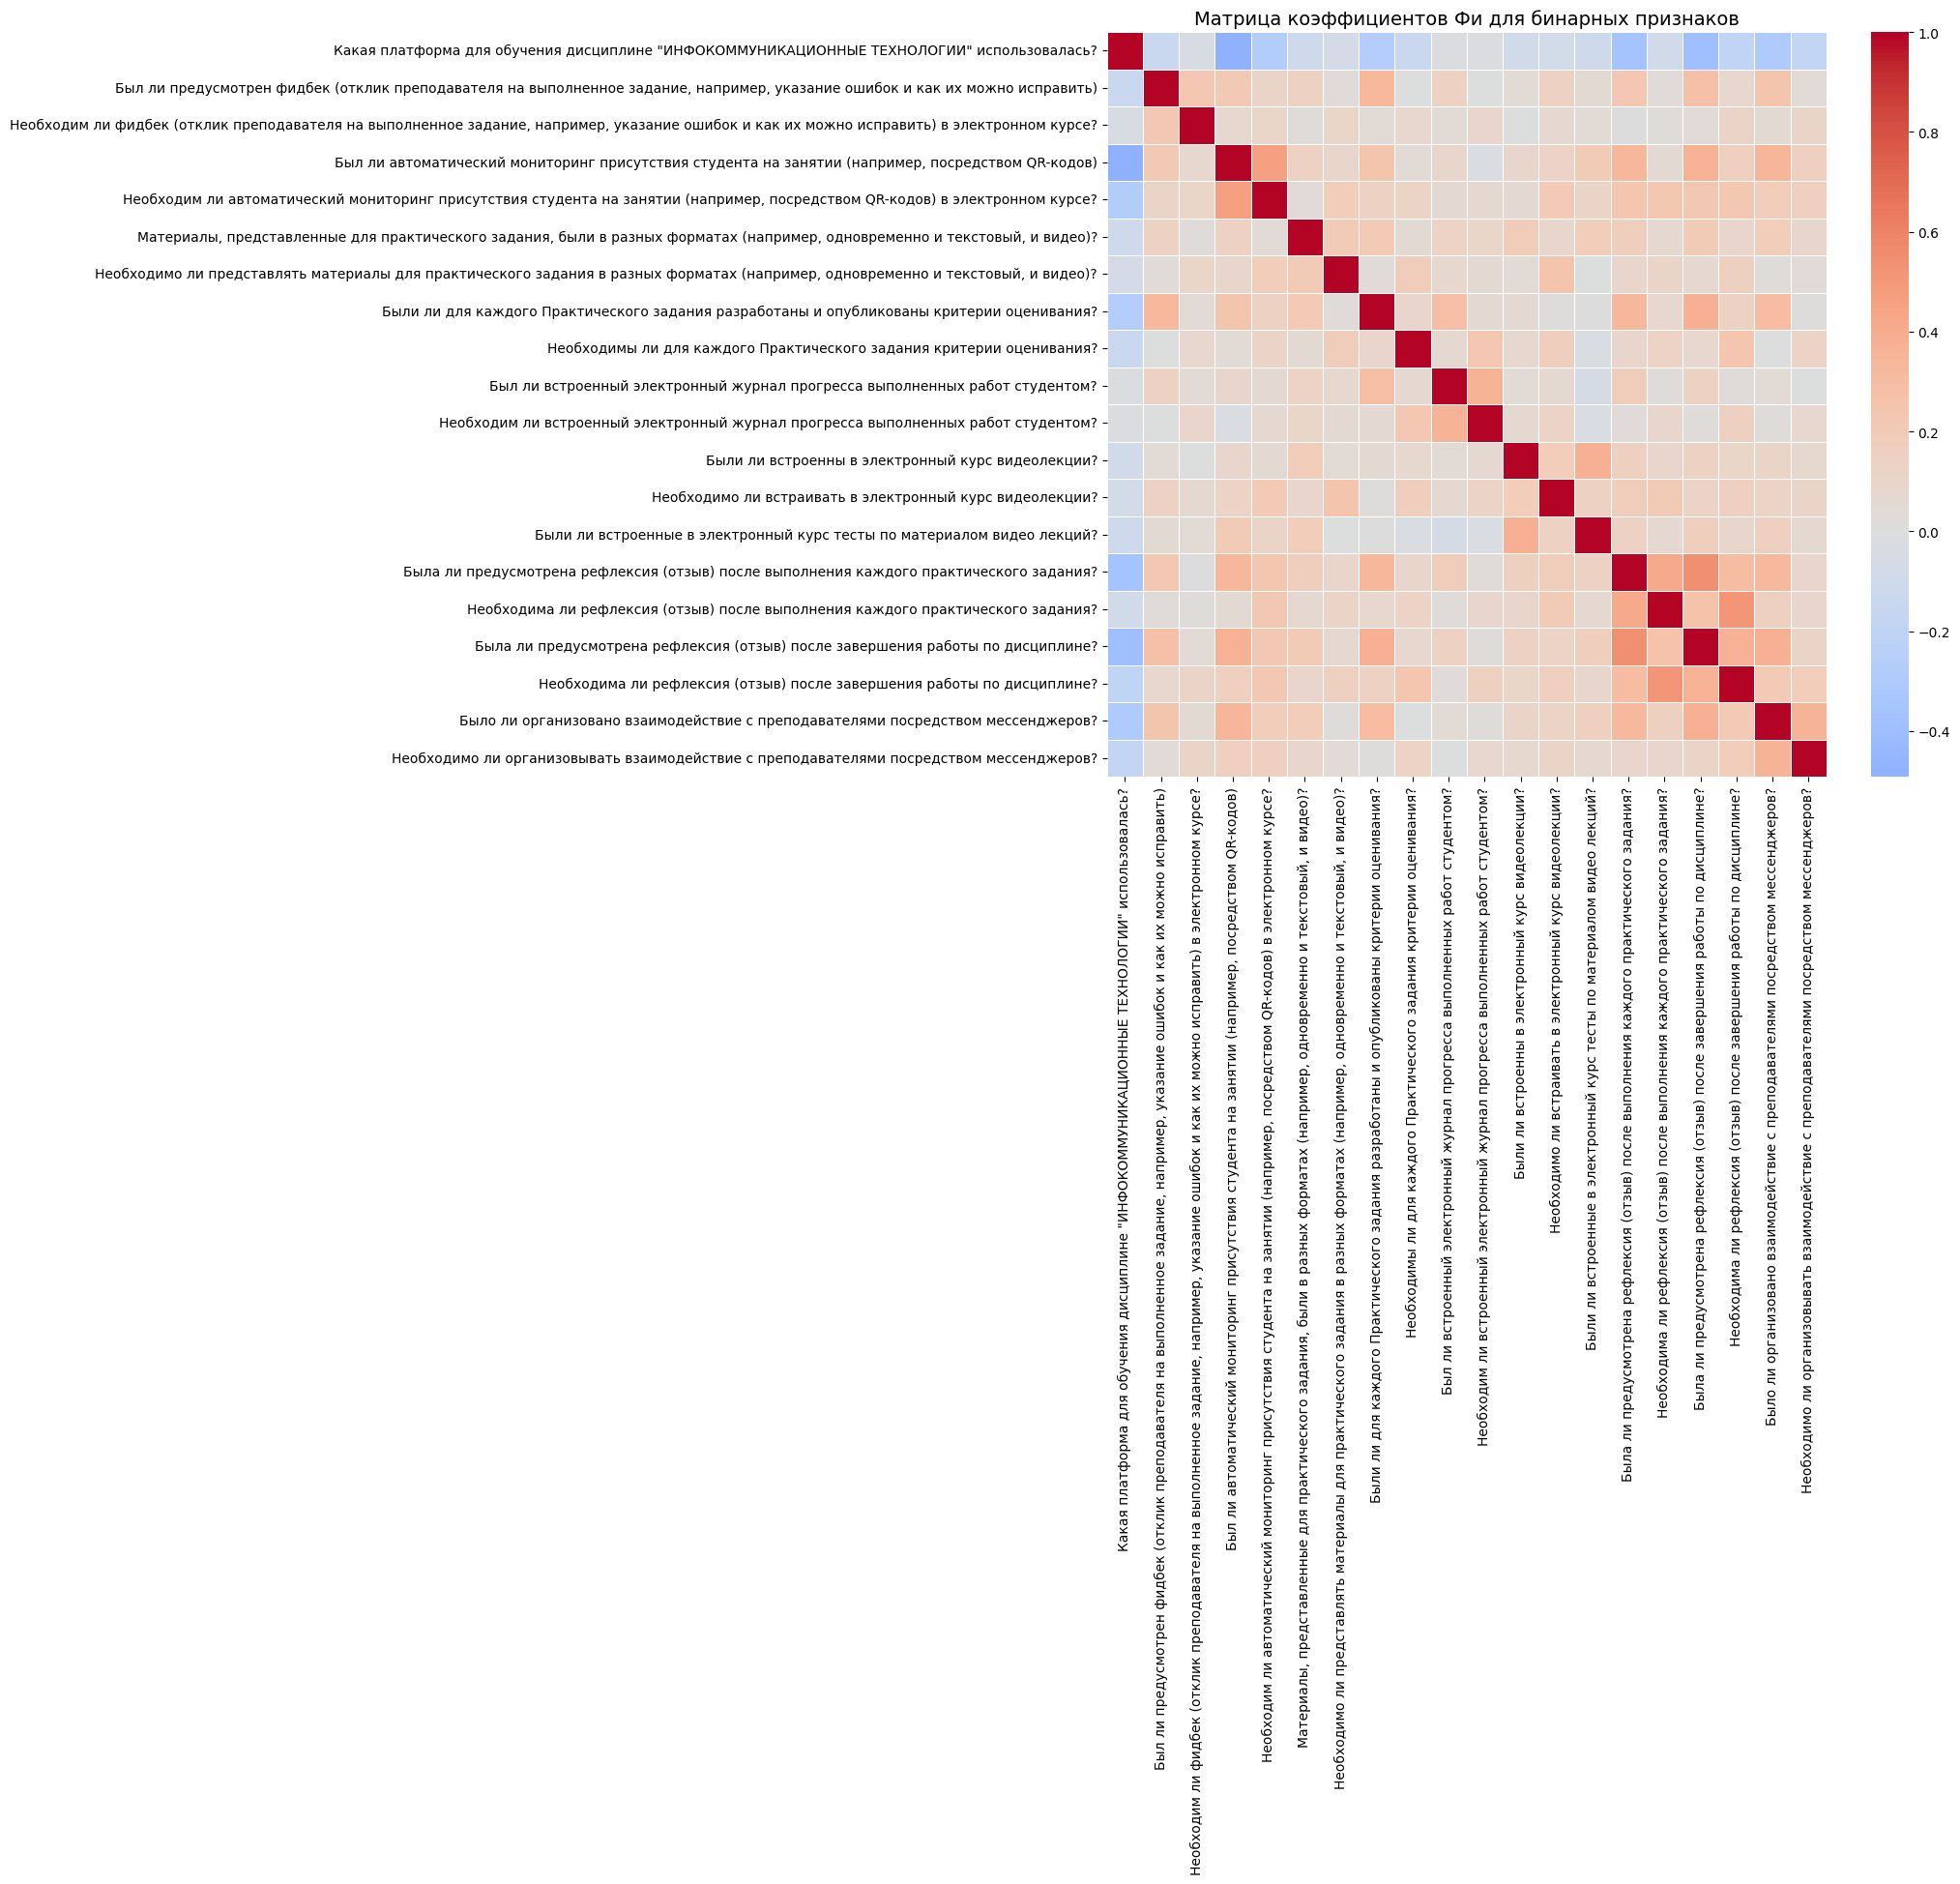

In [9]:
# Матрица коэффициентов Фи
phi_matrix = pd.DataFrame(index=binary_columns, columns=binary_columns)

for col1, col2 in combinations(binary_columns, 2):
    phi = phi_coefficient(df_cleaned[col1], df_cleaned[col2])
    phi_matrix.loc[col1, col2] = phi
    phi_matrix.loc[col2, col1] = phi

np.fill_diagonal(phi_matrix.values, 1.0)
phi_matrix = phi_matrix.astype(float)

# Визуализация тепловой карты коэффициентов Фи
plt.figure(figsize=(12, 10))
sns.heatmap(phi_matrix, cmap="coolwarm", center=0, linewidths=0.5, annot=False)
plt.title("Матрица коэффициентов Фи для бинарных признаков", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Исключаем "институт" и "платформу" — оставляем только бинарные признаки
features_for_clustering = df_cleaned[binary_columns].copy()

print(f"Итоговое количество признаков для кластеризации: {features_for_clustering.shape[1]}")
features_for_clustering.head()

Итоговое количество признаков для кластеризации: 20


,"Какая платформа для обучения дисциплине ""ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ"" использовалась?","Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)","Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?","Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)","Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?","Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?","Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?",Были ли для каждого Практического задания разработаны и опубликованы критерии оценивания?,Необходимы ли для каждого Практического задания критерии оценивания?,Был ли встроенный электронный журнал прогресса выполненных работ студентом?,Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?,Были ли встроенны в электронный курс видеолекции?,Необходимо ли встраивать в электронный курс видеолекции?,Были ли встроенные в электронный курс тесты по материалом видео лекций?,Была ли предусмотрена рефлексия (отзыв) после выполнения каждого практического задания?,Необходима ли рефлексия (отзыв) после выполнения каждого практического задания?,Была ли предусмотрена рефлексия (отзыв) после завершения работы по дисциплине?,Необходима ли рефлексия (отзыв) после завершения работы по дисциплине?,Было ли организовано взаимодействие с преподавателями посредством мессенджеров?,Необходимо ли организовывать взаимодействие с преподавателями посредством мессенджеров?
0,moodle,нет,нет,нет,нет,да,нет,да,да,да,да,да,нет,да,нет,да,нет,да,да,да
1,moodle,да,да,нет,да,нет,да,да,да,да,да,да,да,да,да,да,да,да,да,да
2,moodle,да,да,да,да,да,да,да,да,да,да,да,да,да,да,да,да,да,да,да
3,moodle,да,да,нет,нет,да,да,да,да,да,да,да,да,да,да,да,да,да,да,да
4,moodle,да,да,нет,нет,да,да,нет,нет,да,да,да,да,да,нет,нет,да,нет,нет,да


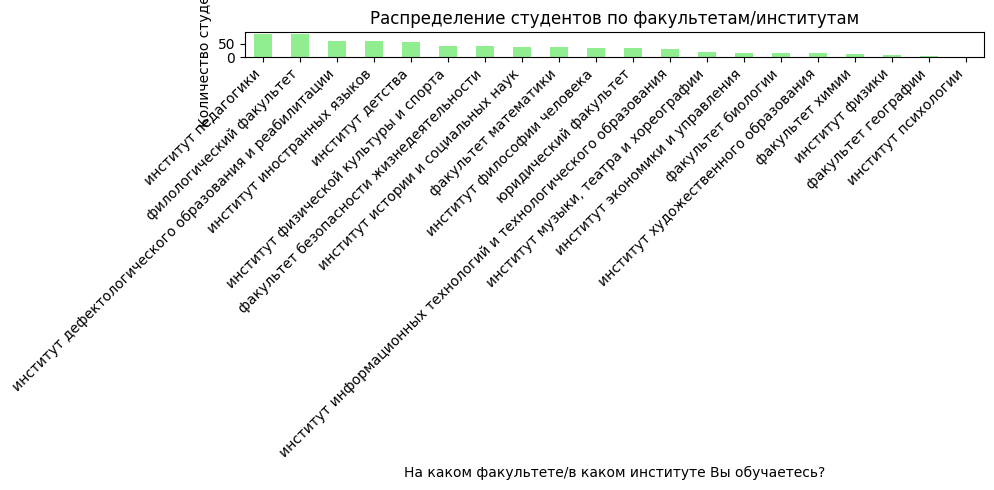

In [13]:
# Распределение по факультетам/институтам
plt.figure(figsize=(10, 5))
df_cleaned["На каком факультете/в каком институте Вы обучаетесь?"].value_counts().plot(kind='bar', color='lightgreen')
plt.title("Распределение студентов по факультетам/институтам")
plt.ylabel("Количество студентов")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **4. Подготовка данных**

In [14]:
# Импорт необходимых библиотек
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder

In [45]:
# Приведение строк к нижнему регистру для унификации
df = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)

# Генерируем новые имена: q1, q2, ..., qN для оставшихся колонок
n_static_cols = 3
question_cols = [f"q{i+1}" for i in range(df.shape[1] - n_static_cols)]
new_columns = list(df.columns[:n_static_cols]) + question_cols
df.columns = new_columns
print(df.columns)

# Удаляем строки, где отсутствуют значения в бинарных признаках (редкие случаи)
df_cleaned = df.dropna(subset=df.columns[3:])
print(f"\nРазмер после удаления строк с пропусками: {df_cleaned.shape}")

Index(['ID', 'Время создания',
       'На каком факультете/в каком институте Вы обучаетесь?', 'q1', 'q2',
       'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13',
       'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20'],
      dtype='object')

Размер после удаления строк с пропусками: (711, 23)


<ipython-input-45-d54a3349e87d>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)


In [46]:
for col in df.columns[3:]:
    print(f"{col}: {df[col].unique()}")

q1: ['moodle' 'авторская платформа преподавателей']
q2: ['нет' 'да']
q3: ['нет' 'да']
q4: ['нет' 'да']
q5: ['нет' 'да']
q6: ['да' 'нет']
q7: ['нет' 'да']
q8: ['да' 'нет']
q9: ['да' 'нет']
q10: ['да' 'нет']
q11: ['да' 'нет']
q12: ['да' 'нет']
q13: ['нет' 'да']
q14: ['да' 'нет']
q15: ['нет' 'да']
q16: ['да' 'нет']
q17: ['нет' 'да']
q18: ['да' 'нет']
q19: ['да' 'нет']
q20: ['да' 'нет']


In [47]:
# Считаем бинарными те признаки, где уникальные значения — только 'да' и 'нет'
binary_cols = [col for col in df.columns[3:] if set(df[col].dropna().unique()) <= {'да', 'нет'}]
print("Бинарные признаки:", binary_cols)

Бинарные признаки: ['q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20']


In [48]:
# Проверка, что во всех бинарных столбцах значения корректные
mask = df[binary_cols].applymap(lambda x: x in ['да', 'нет']).all(axis=1)
df_cleaned = df[mask].copy()
print(f"Размер после фильтрации: {df_cleaned.shape}")

Размер после фильтрации: (711, 23)


<ipython-input-48-82b0430e1f1f>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df[binary_cols].applymap(lambda x: x in ['да', 'нет']).all(axis=1)


In [49]:
df_encoded = df_cleaned.copy()
df_encoded[binary_cols] = df_encoded[binary_cols].applymap(lambda x: 1 if x == 'да' else 0)

<ipython-input-49-e4daa7c2906a>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded[binary_cols] = df_encoded[binary_cols].applymap(lambda x: 1 if x == 'да' else 0)


In [51]:
# Удалим ID, дату и не бинарные признаки
columns_to_drop = list(df.columns[:3])  # первые 3 — ID, дата, факультет
non_binary_cols = [col for col in df.columns[3:] if col not in binary_cols]
df_final = df_encoded.drop(columns=columns_to_drop + non_binary_cols)

print("Итоговый размер подготовленного датасета:", df_final.shape)
df_final.head()
df_final.head()

Итоговый размер подготовленного датасета: (711, 19)


,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19,q20
0,0,0,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,1
1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,0,0,1,1,0,0,1,1,1,1,1,0,0,1,0,0,1


In [59]:
# Базовая проекция в 2D
reducer_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, metric='jaccard')
embedding_2d = reducer_2d.fit_transform(df_final)

# Базовая проекция в 3D
reducer_3d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42, metric='jaccard')
embedding_3d = reducer_3d.fit_transform(df_final)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 1444 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ens

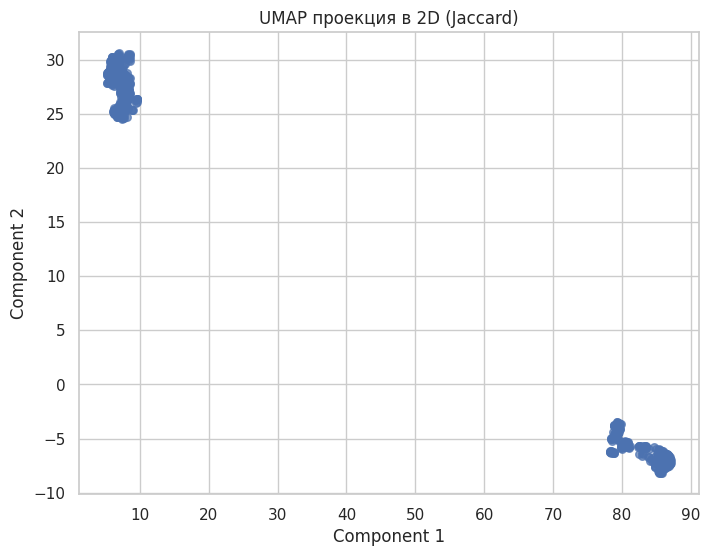

In [60]:
# 2D
plt.figure(figsize=(8, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=30, alpha=0.7)
plt.title("UMAP проекция в 2D (Jaccard)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

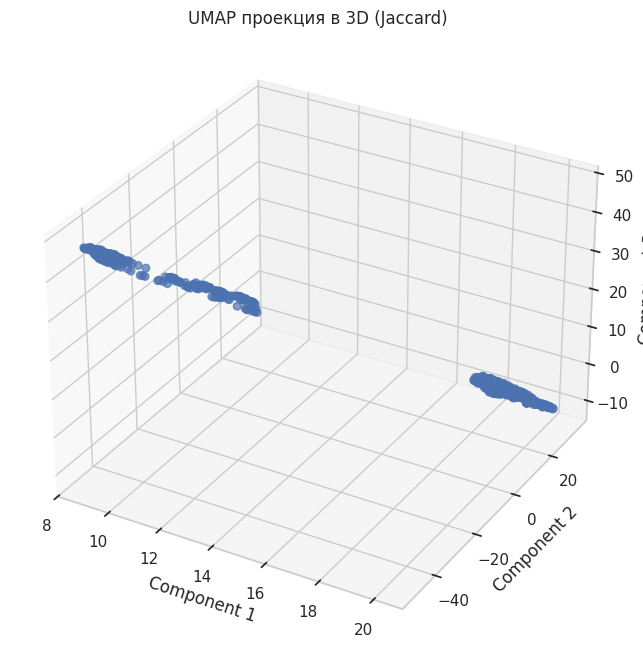

In [61]:
# 3D визуализация
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], s=30, alpha=0.7)
ax.set_title("UMAP проекция в 3D (Jaccard)")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 1444 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


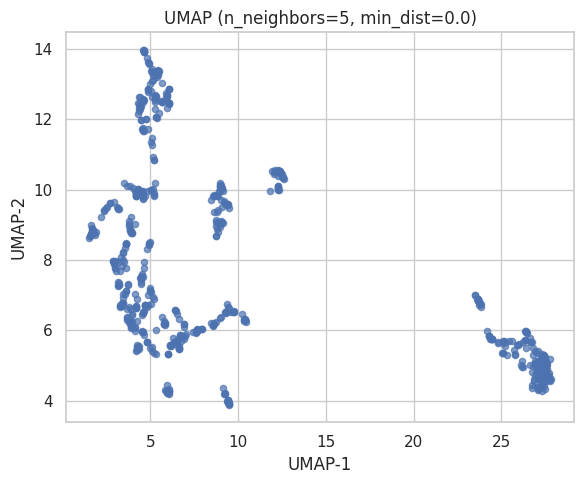

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 1444 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


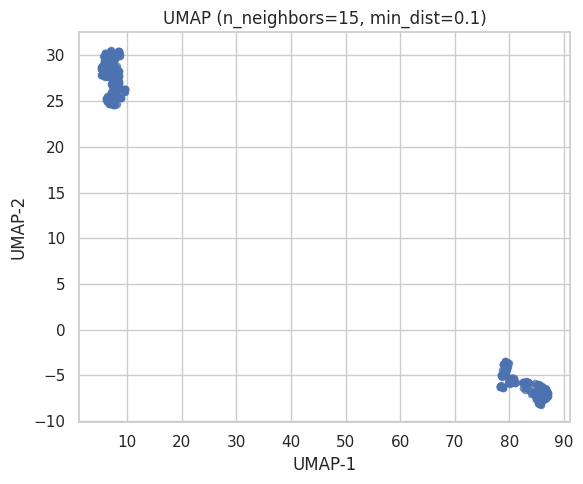

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 1444 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


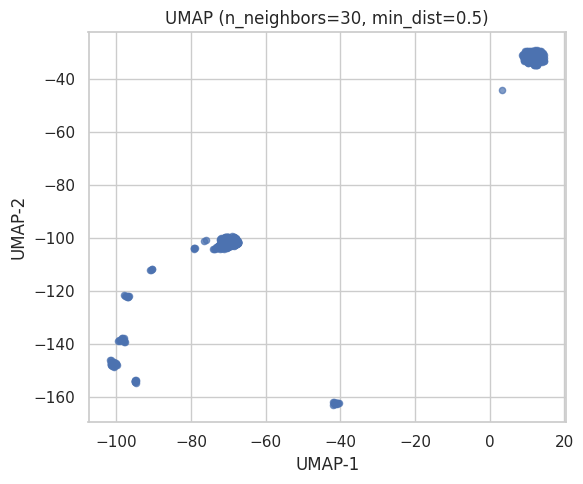

In [62]:
params = [
    {'n_neighbors': 5, 'min_dist': 0.0},
    {'n_neighbors': 15, 'min_dist': 0.1},
    {'n_neighbors': 30, 'min_dist': 0.5},
]

for i, p in enumerate(params):
    reducer = umap.UMAP(n_neighbors=p['n_neighbors'], min_dist=p['min_dist'], n_components=2, random_state=42, metric='jaccard')
    embedding = reducer.fit_transform(df_final)

    plt.figure(figsize=(6, 5))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=20, alpha=0.7)
    plt.title(f"UMAP (n_neighbors={p['n_neighbors']}, min_dist={p['min_dist']})")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [63]:
# Сохраняем 2D и 3D проекции
df_umap = pd.DataFrame(embedding_2d, columns=['UMAP_1', 'UMAP_2'])
df_umap3d = pd.DataFrame(embedding_3d, columns=['UMAP_1', 'UMAP_2', 'UMAP_3'])

### **5. Моделирование**

In [66]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.8 MB/s eta 0:00:00


In [84]:
# Импорт библиотек
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import skfuzzy as fuzz

In [70]:
df_2d = df_umap
df_3d = df_umap3d

# Функция визуализации кластеров
def plot_clusters(data, labels, title="Кластеры"):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=40, alpha=0.8)
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True)
    plt.show()

Размер данных после удаления пропусков: (710, 2)
k=2, silhouette=0.9630
k=3, silhouette=0.8595
k=4, silhouette=0.6127
k=5, silhouette=0.5772
k=6, silhouette=0.5292
k=7, silhouette=0.4614
k=8, silhouette=0.5397
k=9, silhouette=0.5132


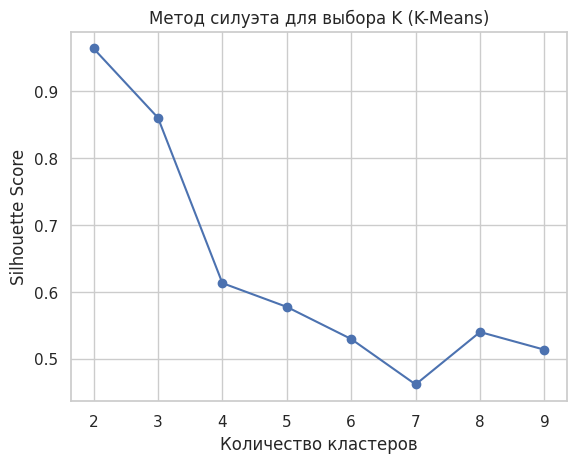

Лучшее количество кластеров: 2


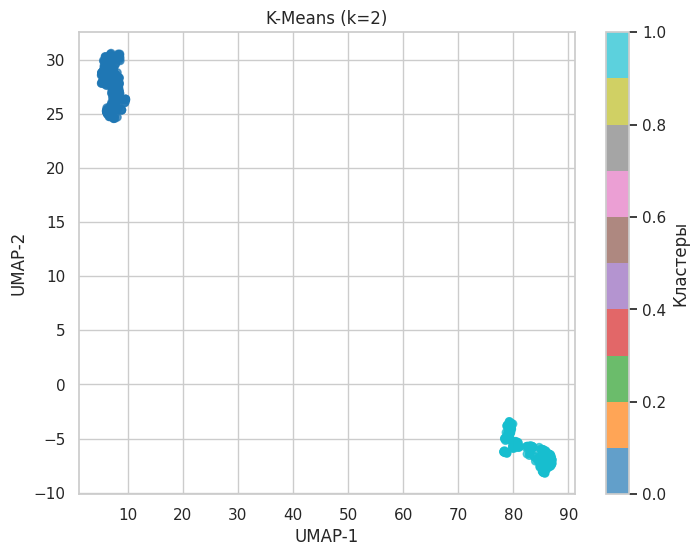

In [73]:
# K-Means
X = df_2d.dropna().values
print(f"Размер данных после удаления пропусков: {X.shape}")
s_scores = []

# Перебираем k от 2 до 9
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    s_scores.append(score)
    print(f"k={k}, silhouette={score:.4f}")

# Визуализируем силуэтный коэффициент в зависимости от количества кластеров
plt.plot(range(2, 10), s_scores, marker='o')
plt.title("Метод силуэта для выбора K (K-Means)")
plt.xlabel("Количество кластеров")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Находим k с максимальным силуэтным коэффициентом
best_k = np.argmax(s_scores) + 2
print(f"Лучшее количество кластеров: {best_k}")

# Финальная модель KMeans с выбранным количеством кластеров
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Функция для визуализации кластеров (2D)
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True)
    plt.colorbar(scatter, label='Кластеры')
    plt.show()

# Визуализируем итоговую кластеризацию
plot_clusters(X, kmeans_labels, f"K-Means (k={best_k})")

k=2, silhouette=0.9630
k=3, silhouette=0.8593
k=4, silhouette=0.5692
k=5, silhouette=0.5749
k=6, silhouette=0.5324
k=7, silhouette=0.5487
k=8, silhouette=0.5386
k=9, silhouette=0.5233


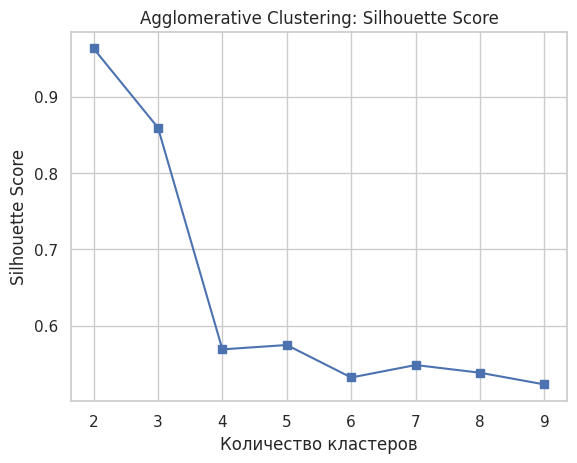

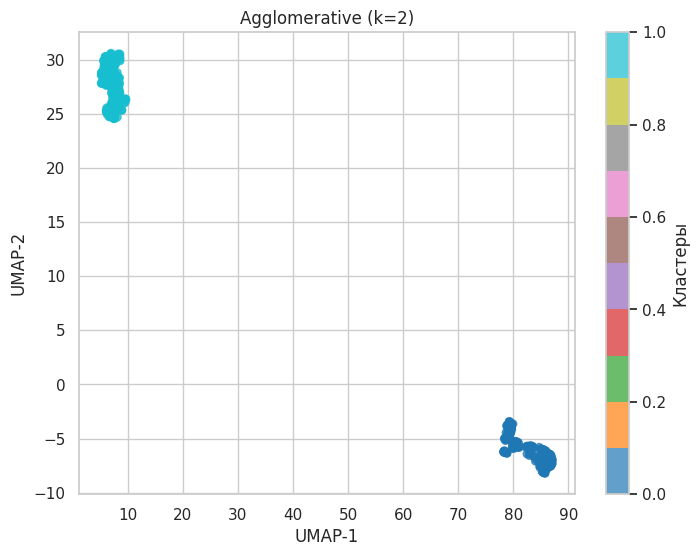

In [74]:
# Agglomerative Clustering
scores = []
for k in range(2, 10):
    ac = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = ac.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)
    print(f"k={k}, silhouette={score:.4f}")

plt.plot(range(2, 10), scores, marker='s')
plt.title("Agglomerative Clustering: Silhouette Score")
plt.xlabel("Количество кластеров")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Лучший k
best_k_ac = np.argmax(scores) + 2
ac = AgglomerativeClustering(n_clusters=best_k_ac)
ac_labels = ac.fit_predict(X)
plot_clusters(X, ac_labels, f"Agglomerative (k={best_k_ac})")

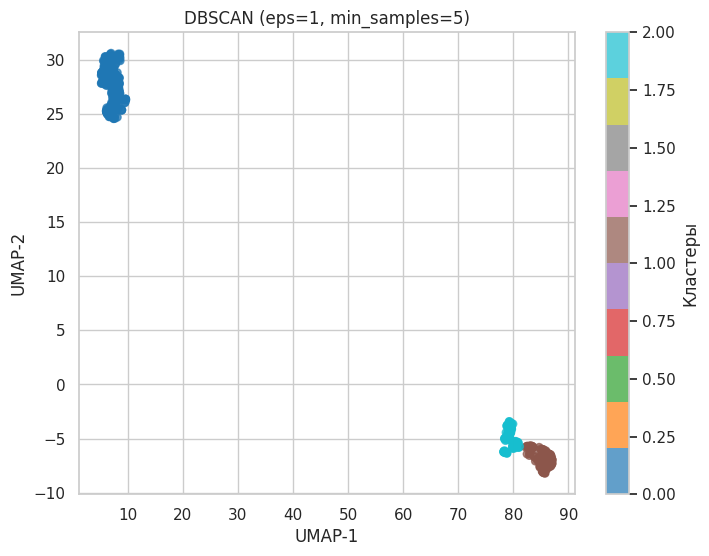

In [83]:
# DBSCAN
db = DBSCAN(eps=1, min_samples=5)
db_labels = db.fit_predict(X)
plot_clusters(X, db_labels, "DBSCAN (eps=1, min_samples=5)")

k=2, silhouette=0.9630
k=3, silhouette=0.8593
k=4, silhouette=0.6179
k=5, silhouette=0.5823
k=6, silhouette=0.5409
k=7, silhouette=0.4617
k=8, silhouette=0.5000
k=9, silhouette=0.5196


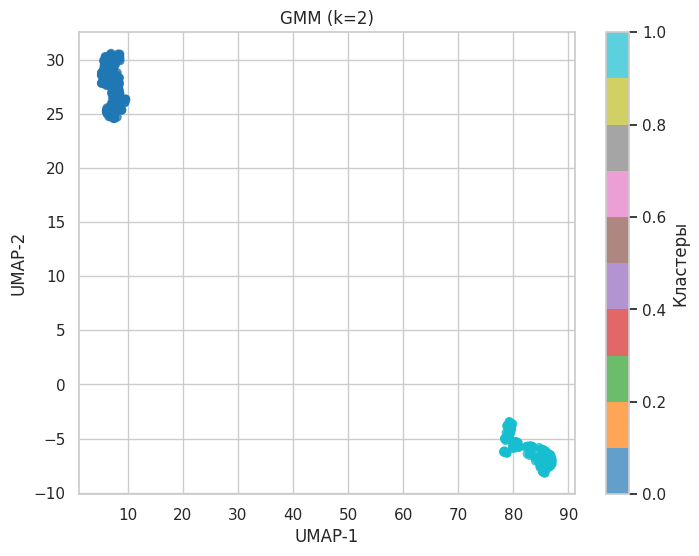

In [77]:
# GMM
scores = []
for k in range(2, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)
    print(f"k={k}, silhouette={score:.4f}")

best_k_gmm = np.argmax(scores) + 2
gmm = GaussianMixture(n_components=best_k_gmm, random_state=42)
gmm_labels = gmm.fit_predict(X)
plot_clusters(X, gmm_labels, f"GMM (k={best_k_gmm})")

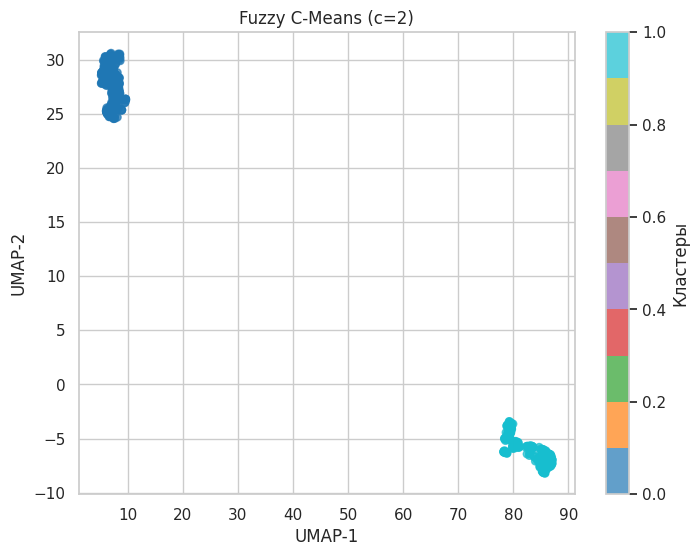

In [79]:
# 5️⃣ Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X.T, c=best_k, m=2, error=0.005, maxiter=1000, init=None)

fcm_labels = np.argmax(u, axis=0)
plot_clusters(X, fcm_labels, f"Fuzzy C-Means (c={best_k})")

### **6. Оценка**

In [87]:
X = df_2d.fillna(df_2d.mean()).values

# Функция для оценки и сбора метрик
def evaluate_clustering(X, labels):
    """
    Рассчитывает метрики силуэта и Davies-Bouldin для меток кластеров.
    Возвращает словарь с результатами.
    """
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters <= 1:
        return {'silhouette': np.nan, 'davies_bouldin': np.nan, 'n_clusters': n_clusters}

    # Считаем коэффициент силуэта
    sil_score = silhouette_score(X, labels)

    # Считаем индекс Дэвиса-Болдина
    db_score = davies_bouldin_score(X, labels)

    return {'silhouette': sil_score, 'davies_bouldin': db_score, 'n_clusters': n_clusters}

# Словарь для хранения результатов
results = []

In [88]:
# K-Means
print("Оценка K-Means моделей")
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    metrics = evaluate_clustering(X, labels)
    results.append({
        'model': 'KMeans',
        'params': f'n_clusters={k}',
        **metrics
    })
    print(f"K={k} | Silhouette={metrics['silhouette']:.4f} | Davies-Bouldin={metrics['davies_bouldin']:.4f}")

Оценка K-Means моделей
K=2 | Silhouette=0.9611 | Davies-Bouldin=0.0594
K=3 | Silhouette=0.9245 | Davies-Bouldin=0.0667
K=4 | Silhouette=0.8430 | Davies-Bouldin=0.1979
K=5 | Silhouette=0.6118 | Davies-Bouldin=0.4586
K=6 | Silhouette=0.5527 | Davies-Bouldin=0.6510
K=7 | Silhouette=0.5952 | Davies-Bouldin=0.5299
K=8 | Silhouette=0.5114 | Davies-Bouldin=0.6739
K=9 | Silhouette=0.5429 | Davies-Bouldin=0.5857


In [92]:
# Agglomerative Clustering
print("Оценка Agglomerative Clustering")
linkages = ['ward', 'complete', 'average', 'single']
for linkage in linkages:
    for k in range(2, 10):
        # Метод 'ward' работает только с Евклидовым расстоянием
        if linkage == 'ward':
            agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        else:
            agg = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric='euclidean')
        labels = agg.fit_predict(X)
        metrics = evaluate_clustering(X, labels)
        results.append({
            'model': 'Agglomerative',
            'params': f'linkage={linkage}, n_clusters={k}',
            **metrics
        })
        print(f"linkage={linkage}, K={k} | Silhouette={metrics['silhouette']:.4f} | Davies-Bouldin={metrics['davies_bouldin']:.4f}")

Оценка Agglomerative Clustering
linkage=ward, K=2 | Silhouette=0.9609 | Davies-Bouldin=0.0597
linkage=ward, K=3 | Silhouette=0.8549 | Davies-Bouldin=0.2665
linkage=ward, K=4 | Silhouette=0.8428 | Davies-Bouldin=0.1958
linkage=ward, K=5 | Silhouette=0.5684 | Davies-Bouldin=0.5208
linkage=ward, K=6 | Silhouette=0.5740 | Davies-Bouldin=0.5453
linkage=ward, K=7 | Silhouette=0.5316 | Davies-Bouldin=0.5296
linkage=ward, K=8 | Silhouette=0.5479 | Davies-Bouldin=0.4840
linkage=ward, K=9 | Silhouette=0.5378 | Davies-Bouldin=0.5526
linkage=complete, K=2 | Silhouette=0.9611 | Davies-Bouldin=0.0594
linkage=complete, K=3 | Silhouette=0.9245 | Davies-Bouldin=0.0667
linkage=complete, K=4 | Silhouette=0.8428 | Davies-Bouldin=0.1958
linkage=complete, K=5 | Silhouette=0.5797 | Davies-Bouldin=0.5031
linkage=complete, K=6 | Silhouette=0.5373 | Davies-Bouldin=0.4918
linkage=complete, K=7 | Silhouette=0.5372 | Davies-Bouldin=0.5249
linkage=complete, K=8 | Silhouette=0.5281 | Davies-Bouldin=0.5642
linkage=co

In [93]:
# DBSCAN
print("Оценка DBSCAN")
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 7]
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        metrics = evaluate_clustering(X, labels)
        results.append({
            'model': 'DBSCAN',
            'params': f'eps={eps}, min_samples={min_samples}',
            **metrics
        })
        print(f"eps={eps}, min_samples={min_samples} | Silhouette={metrics['silhouette']:.4f} | Davies-Bouldin={metrics['davies_bouldin']:.4f}")

Оценка DBSCAN
eps=0.3, min_samples=3 | Silhouette=0.2715 | Davies-Bouldin=1.0237
eps=0.3, min_samples=5 | Silhouette=0.3648 | Davies-Bouldin=1.0115
eps=0.3, min_samples=7 | Silhouette=0.3165 | Davies-Bouldin=1.0063
eps=0.5, min_samples=3 | Silhouette=0.3576 | Davies-Bouldin=0.9999
eps=0.5, min_samples=5 | Silhouette=0.3218 | Davies-Bouldin=1.0487
eps=0.5, min_samples=7 | Silhouette=0.3618 | Davies-Bouldin=1.4647
eps=0.7, min_samples=3 | Silhouette=0.4122 | Davies-Bouldin=0.4710
eps=0.7, min_samples=5 | Silhouette=0.4122 | Davies-Bouldin=0.4710
eps=0.7, min_samples=7 | Silhouette=0.3481 | Davies-Bouldin=0.4846
eps=1.0, min_samples=3 | Silhouette=0.8428 | Davies-Bouldin=0.1958
eps=1.0, min_samples=5 | Silhouette=0.8428 | Davies-Bouldin=0.1958
eps=1.0, min_samples=7 | Silhouette=0.8428 | Davies-Bouldin=0.1958


In [94]:
# Gaussian Mixture Models (GMM)
print("Оценка GMM")
for k in range(2, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X)
    metrics = evaluate_clustering(X, labels)
    results.append({
        'model': 'GMM',
        'params': f'n_components={k}',
        **metrics
    })
    print(f"K={k} | Silhouette={metrics['silhouette']:.4f} | Davies-Bouldin={metrics['davies_bouldin']:.4f}")

Оценка GMM
K=2 | Silhouette=0.9609 | Davies-Bouldin=0.0597
K=3 | Silhouette=0.9245 | Davies-Bouldin=0.0667
K=4 | Silhouette=0.8428 | Davies-Bouldin=0.1958
K=5 | Silhouette=0.6170 | Davies-Bouldin=0.4364
K=6 | Silhouette=0.5548 | Davies-Bouldin=0.6019
K=7 | Silhouette=0.5473 | Davies-Bouldin=0.5287
K=8 | Silhouette=0.5063 | Davies-Bouldin=0.6527
K=9 | Silhouette=0.5342 | Davies-Bouldin=0.5982


In [95]:
# 5. Fuzzy C-Means
print("Оценка Fuzzy C-Means")
cntr, u, u0, d, jm, p, fpc = None, None, None, None, None, None, None
for k in range(2, 10):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, c=k, m=2, error=0.005, maxiter=1000, init=None)
    labels = np.argmax(u, axis=0)
    metrics = evaluate_clustering(X, labels)
    results.append({
        'model': 'Fuzzy C-Means',
        'params': f'clusters={k}, m=2',
        **metrics
    })
    print(f"K={k} | Silhouette={metrics['silhouette']:.4f} | Davies-Bouldin={metrics['davies_bouldin']:.4f}")

Оценка Fuzzy C-Means
K=2 | Silhouette=0.9611 | Davies-Bouldin=0.0594
K=3 | Silhouette=0.8540 | Davies-Bouldin=0.2675
K=4 | Silhouette=0.6967 | Davies-Bouldin=0.4181
K=5 | Silhouette=0.6584 | Davies-Bouldin=0.5505
K=6 | Silhouette=0.5797 | Davies-Bouldin=0.4653
K=7 | Silhouette=0.5414 | Davies-Bouldin=0.5529
K=8 | Silhouette=0.5257 | Davies-Bouldin=0.6239
K=9 | Silhouette=0.5358 | Davies-Bouldin=0.6207


In [96]:
df_results = pd.DataFrame(results)

# Сортируем по силуэту
df_results_sorted = df_results.sort_values(by='silhouette', ascending=False)

print("\nТоп-10 моделей по коэффициенту силуэта:")
print(df_results_sorted.head(10))


Топ-10 моделей по коэффициенту силуэта:
             model                          params  silhouette  \
0           KMeans                    n_clusters=2    0.961051   
40   Agglomerative    linkage=single, n_clusters=2    0.961051   
32   Agglomerative   linkage=average, n_clusters=2    0.961051   
24   Agglomerative  linkage=complete, n_clusters=2    0.961051   
112  Fuzzy C-Means                 clusters=2, m=2    0.961051   
84   Agglomerative    linkage=single, n_clusters=2    0.961051   
76   Agglomerative   linkage=average, n_clusters=2    0.961051   
68   Agglomerative  linkage=complete, n_clusters=2    0.961051   
16   Agglomerative      linkage=ward, n_clusters=2    0.960852   
8    Agglomerative      linkage=ward, n_clusters=2    0.960852   

     davies_bouldin  n_clusters  
0          0.059355           2  
40         0.059355           2  
32         0.059355           2  
24         0.059355           2  
112        0.059355           2  
84         0.059355         

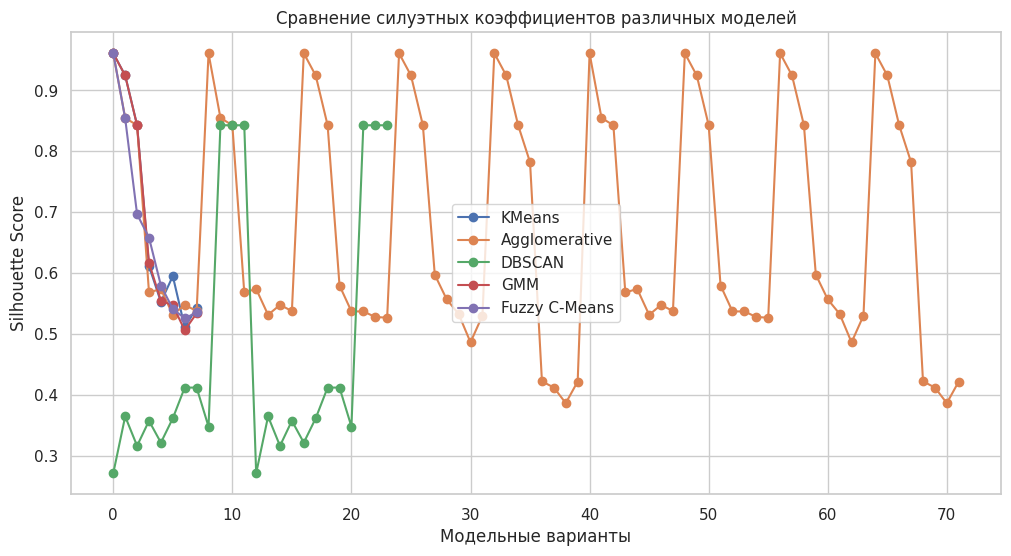

In [97]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
for model in df_results['model'].unique():
    subset = df_results[df_results['model'] == model]
    plt.plot(range(len(subset)), subset['silhouette'], marker='o', label=model)
plt.title("Сравнение силуэтных коэффициентов различных моделей")
plt.xlabel("Модельные варианты")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

In [99]:
best_model_row = df_results_sorted.iloc[0]
print(f"\nЛучший результат у модели:\n{best_model_row}")


Лучший результат у модели:
model                   KMeans
params            n_clusters=2
silhouette            0.961051
davies_bouldin        0.059355
n_clusters                   2
Name: 0, dtype: object


In [100]:
# Используем лучшую модель для интерпретации кластеров
best_k = int(best_model_row['params'].split('=')[1])
best_model = KMeans(n_clusters=best_k, random_state=42)
best_labels = best_model.fit_predict(X)

In [102]:
# Добавляем метки к исходному датафрейму с бинарными признаками
df_with_clusters = df_final.copy()
df_with_clusters['cluster'] = best_labels

cluster_summary = df_with_clusters.groupby('cluster').mean()
print("\nСредние значения признаков по кластерам:")
display(cluster_summary)


Средние значения признаков по кластерам:


,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19,q20
cluster,,,,,,,,,,,,,,,,,,,
0,0.779891,0.923913,0.179348,0.230978,0.872283,0.839674,0.627717,0.888587,0.760870,0.918478,0.902174,0.736413,0.828804,0.394022,0.554348,0.369565,0.622283,0.529891,0.812500
1,0.927114,0.938776,0.903790,0.793003,0.959184,0.924198,0.935860,0.921283,0.827988,0.915452,0.976676,0.883382,0.956268,0.915452,0.769679,0.956268,0.880466,0.962099,0.932945


In [103]:
for cluster_id in cluster_summary.index:
    print(f"\nКластер {cluster_id}:")
    cluster_desc = cluster_summary.loc[cluster_id]
    top_features = cluster_desc.sort_values(ascending=False).head(3)
    print(f"Преобладающие признаки: {list(top_features.index)} с средним значением {list(top_features.values)}")


Кластер 0:
Преобладающие признаки: ['q3', 'q11', 'q12'] с средним значением [np.float64(0.9239130434782609), np.float64(0.9184782608695652), np.float64(0.9021739130434783)]

Кластер 1:
Преобладающие признаки: ['q12', 'q19', 'q6'] с средним значением [np.float64(0.9766763848396501), np.float64(0.9620991253644315), np.float64(0.9591836734693877)]


Преобладающие признаки для кластера 0:
- Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?
- Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?
- Были ли встроенны в электронный курс видеолекции?

Преобладающие признаки для кластера 1:
- Были ли встроенны в электронный курс видеолекции?
- Было ли организовано взаимодействие с преподавателями посредством мессенджеров?
- Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?

### **7. Визуализация и представление результатов**

In [110]:
# Импорт библиотек
from math import pi

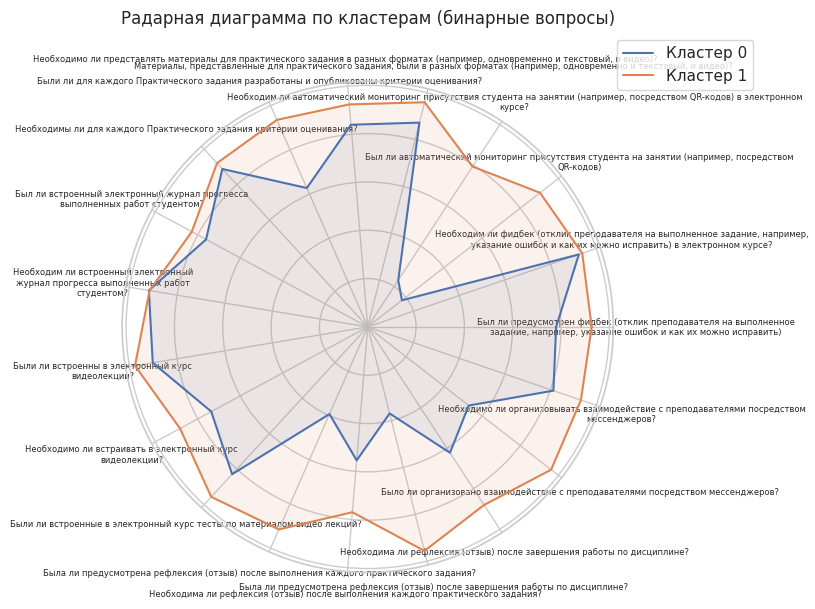

In [111]:
questions = [
    "Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)",
    "Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?",
    "Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)",
    "Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?",
    "Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?",
    "Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?",
    "Были ли для каждого Практического задания разработаны и опубликованы критерии оценивания?",
    "Необходимы ли для каждого Практического задания критерии оценивания?",
    "Был ли встроенный электронный журнал прогресса выполненных работ студентом?",
    "Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?",
    "Были ли встроенны в электронный курс видеолекции?",
    "Необходимо ли встраивать в электронный курс видеолекции?",
    "Были ли встроенные в электронный курс тесты по материалом видео лекций?",
    "Была ли предусмотрена рефлексия (отзыв) после выполнения каждого практического задания?",
    "Необходима ли рефлексия (отзыв) после выполнения каждого практического задания?",
    "Была ли предусмотрена рефлексия (отзыв) после завершения работы по дисциплине?",
    "Необходима ли рефлексия (отзыв) после завершения работы по дисциплине?",
    "Было ли организовано взаимодействие с преподавателями посредством мессенджеров?",
    "Необходимо ли организовывать взаимодействие с преподавателями посредством мессенджеров?"
]

def plot_radar_chart(data, title, labels):
    num_vars = len(labels)

    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for idx, row in data.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, label=f"Кластер {idx}")
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=6, wrap=True)  # fontsize поменьше, можно добавить wrap

    ax.set_yticklabels([])
    plt.title(title, size=12, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

binary_cols = [col for col in df_with_clusters.columns if col.startswith("q") and col[1:].isdigit()]
cluster_profile = df_with_clusters.groupby("cluster")[binary_cols].mean()

plot_radar_chart(cluster_profile, "Радарная диаграмма по кластерам (бинарные вопросы)", questions)

### **8. Общие выводы по работе**

В ходе выполнения работы по кластерному анализу опроса студентов была успешно применена методология CRISP-DM.

Полученные результаты могут быть использованы университетом для улучшения качества образовательного процесса.